In [1]:
import numpy as np
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
# import mpl_toolkits
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits.mplot3d import Axes3D
# import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
# import pyemma
from pyemma import msm
%matplotlib inline

In [2]:
expedia = pd.read_csv('./data/expedia_train.csv')
# get most data of hotel id 104517
df = expedia.loc[expedia['prop_id'] == 104517]
df = df.loc[df['srch_room_count'] == 1]
# select America
df = df.loc[df['visitor_location_country_id'] == 219]
df = df[['date_time', 'price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]

In [3]:
df['price_usd'].describe()

count    3049.000000
mean      112.939023
std       113.374049
min         0.120000
25%        67.000000
50%       100.000000
75%       141.000000
max      5584.000000
Name: price_usd, dtype: float64

In [4]:
expedia.loc[(expedia['price_usd'] == 5584) & (expedia['visitor_location_country_id'] == 219)]

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
2905344,195154,2013-04-07 20:59:07,5,219,NaN,NaN,219,104517,4,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,28.0,0,NaN,0


In [5]:
df = df.loc[df['price_usd'] < 5584]

Text(0.5, 1.0, 'Time Series of room price by date time of search')

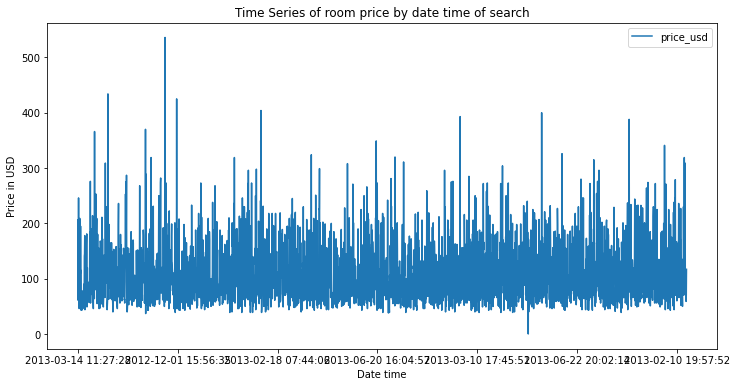

In [6]:
df.plot(x='date_time', y='price_usd', figsize=(12, 6))
plt.xlabel('Date time')
plt.ylabel('Price in USD')
plt.title('Time Series of room price by date time of search')

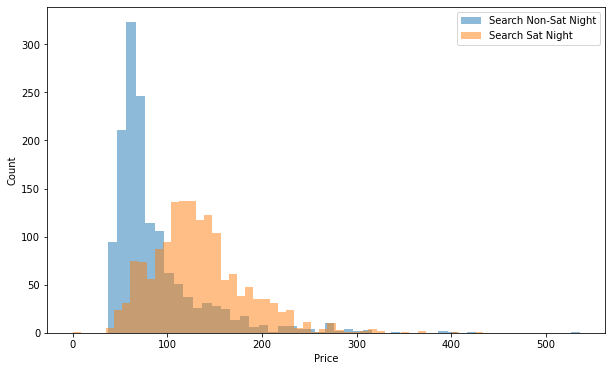

In [7]:
a = df.loc[df['srch_saturday_night_bool'] == 0, 'price_usd']
b = df.loc[df['srch_saturday_night_bool'] == 1, 'price_usd']
plt.figure(figsize=(10, 6))
plt.hist(a, bins=50, alpha=.5, label='Search Non-Sat Night')
plt.hist(b, bins=50, alpha=.5, label='Search Sat Night')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

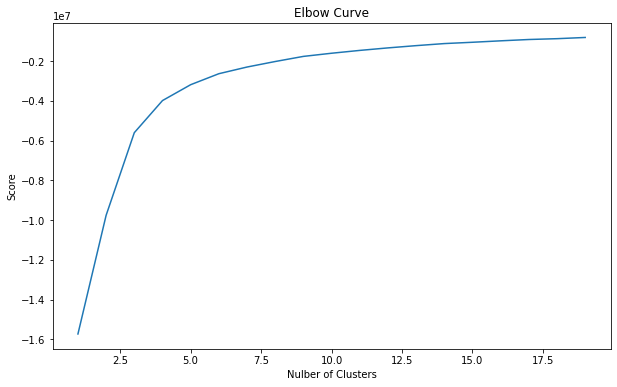

In [8]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_cluster, scores)
plt.xlabel('Nulber of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

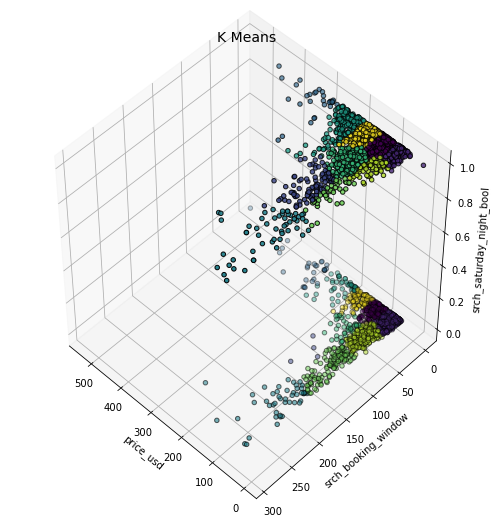

In [9]:
X = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
labels = km.labels_

# plotting
fig = plt.figure(1, figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:, 0], X.iloc[:, 1], X.iloc[:, 2], c=labels.astype(np.float), edgecolor='k')
ax.set_xlabel('price_usd')
ax.set_ylabel('srch_booking_window')
ax.set_zlabel('srch_saturday_night_bool')
plt.title('K Means', fontsize=14)
plt.show()

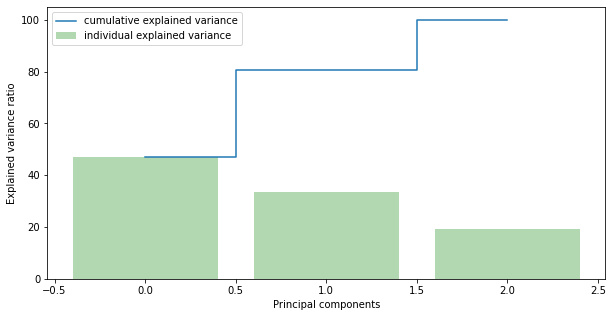

In [10]:
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
X = data.values
X_std = StandardScaler().fit_transform(X)
mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]
eig_pairs.sort(key = lambda x: x[0], reverse=True)
tot = sum(eig_vals)
# Individual explained variance
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
# cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=.3, align='center', label='individual explained variance', color='g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show()



In [11]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0, len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i] - 1]
        # print(Xa - Xb, np.linalg.norm(Xa - Xb))      
        distance.append(pd.Series(np.linalg.norm(Xa - Xb)))  
    return distance

In [12]:
outliers_fraction = 0.01
# the following code cannot work because of code lacking

# get the distance between each point and its nearest centroid.
# The biggest distances are considered as anomaly

# distance = getDistanceByPoint(data, kmeans[9])
# number_of_outliers = int(outliers_fraction * len(distance))
# threshold = distance.nlargest(number_of_outliers).min()

# anomaly contain the anomaly result of the above method Cluster (0: normal, 1: anomaly)

# df['anomaly1'] = (distance >= threshold).astype(int)

# visualisation of anomaly with cluster view

# fig, ax = plt.subplots(figsize=(10, 6))
# colors = {0: 'blue', 1: 'red'}
# ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df['anomaly1'].apply(lambda x: colors[x]))
# plt.xlabel('principal feature 1')
# plt.ylabel('principal feature 2')
# plt.show()

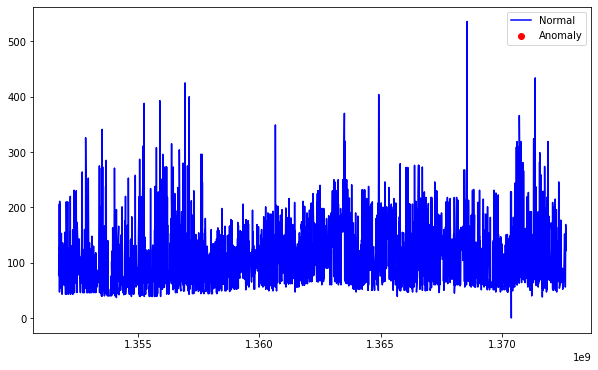

In [13]:
df = df.sort_values('date_time')
df['date_time_int'] = pd.to_datetime(df['date_time']).astype(np.int64) // 10 ** 9
data = df[['price_usd', 'srch_booking_window', 'srch_saturday_night_bool']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest
model = IsolationForest(contamination=outliers_fraction)
model.fit(data)
df['anomaly2'] = pd.Series(model.predict(data))

# visualization
fig, ax = plt.subplots(figsize=(10, 6))
a = df.loc[df['anomaly2'] == -1]
a = a[['date_time_int', 'price_usd']]

ax.plot(df['date_time_int'], df['price_usd'], color='blue', label='Normal')
ax.scatter(a['date_time_int'], a['price_usd'], color='red', label='Anomaly')
plt.legend()
plt.show()